In [ ]:
#four layers
#dense; ReLU; embedding; mean

In [38]:
# To silence the TensorFlow warnings, you can use the following code before you import the TensorFlow library.
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers
from tensorflow.keras import losses
import re
import string
import matplotlib.pyplot as plt
from numpy import random
from time import perf_counter

print("Imports successful!")

Imports successful!


In [3]:
#print(tf.__version__)

In [4]:
# Select your favourite number for the random seed
seed = 42

# Sets the global random seed for numpy.
np.random.seed(seed)
# Sets the global random seed for TensorFlow.
tf.random.set_seed(seed)

print(f"Random seed set to {seed}")

Random seed set to 42


In [5]:
data_dir = './data/aclImdb'

In [6]:
# Here you have two main directories: one for train and one for test data.
# You load files from each to create training and test datasets.
seed = 42
# Create the training set. Use 80% of the data and keep the remaining 20% for the validation.
raw_training_set = tf.keras.utils.text_dataset_from_directory(
    f'{data_dir}/train',
    labels='inferred',
    label_mode='int',
    batch_size=32, 
    validation_split=0.2, 
    subset='training', 
    seed=seed
)

# Create the validation set. Use 20% of the data that was not used for training.
raw_validation_set = tf.keras.utils.text_dataset_from_directory(
    f'{data_dir}/train',
    labels='inferred',
    label_mode='int',
    batch_size=32, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed
)

# Create the test set.
raw_test_set = tf.keras.utils.text_dataset_from_directory(
    f'{data_dir}/test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
)

Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Found 5000 files belonging to 2 classes.


In [7]:
print(f"Label 0 corresponds to {raw_training_set.class_names[0]}")
print(f"Label 1 corresponds to {raw_training_set.class_names[1]}")

Label 0 corresponds to neg
Label 1 corresponds to pos


In [8]:
# Take one batch from the dataset and print out the first three datapoints in the batch
for text_batch, label_batch in raw_training_set.take(1):
    for i in range(3):
        print(f"Review:\n {text_batch.numpy()[i]}")
        print(f"Label: {label_batch.numpy()[i]}\n")

Review:
 b'This is a reunion, a team, and a great episode of Justice. From hesitation to resolution, Clark has made a important leap from a troubled teenager who was afraid of a controlled destiny, to a Superman who, like Green Arrow, sets aside his emotions to his few loved ones, ready to save the whole planet. This is not just a thrilling story about teamwork, loyalty, and friendship; this is also about deciding what\'s more important in life, a lesson for Clark. I do not want the series to end, but I hope the ensuing episodes will strictly stick to what Justice shows without any "rewind" pushes and put a good end here of Smallville---and a wonderful beginning of Superman.<br /><br />In this episode, however, we should have seen more contrast between Lex and the Team. Nine stars should give it enough credit.'
Label: 1

Review:
 b'"Hey Babu Riba" is a film about a young woman, Mariana (nicknamed "Esther" after a famous American movie star), and four young men, Glenn, Sacha, Kicha, and

In [9]:
# Set the maximum number of words
max_features = 10000

# Define the custom standardization function
def custom_standardization(input_data):
    # Convert all text to lowercase
    lowercase = tf.strings.lower(input_data)
    # Remove HTML tags
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    # Remove punctuation
    replaced = tf.strings.regex_replace(
        stripped_html,
        '[%s]' % re.escape(string.punctuation),
        ''
    )
    return replaced

# Create a layer that you can use to convert text to vectors
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=250)

In [10]:
# Build the vocabulary
train_text = raw_training_set.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

# Print out the vocabulary size
print(f"Vocabulary size: {len(vectorize_layer.get_vocabulary())}")

Vocabulary size: 10000


In [11]:
# Define the final function that you will use to vectorize the text.
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Get one batch and select the first datapoint
text_batch, label_batch = next(iter(raw_training_set))
first_review, first_label = text_batch[0], label_batch[0]

# Show the raw data
print(f"Review:\n{first_review}")
print(f"\nLabel: {raw_training_set.class_names[first_label]}")
# Show the vectorized data
print(f"\nVectorized review\n{vectorize_text(first_review, first_label)}")

Review:
b"This movie is about a side of Ireland that Americans don't normally see, the narrow-minded religiously prejudiced side of the 'friendliest race in the world'. The movie, by the admission of the inhabitants of Fethard who are old enough to remember the events, is fairly accurate (though they insist that the film-makers invented some of the more violent scenes just to spice up the action).<br /><br />The movie was very unpopular in Ireland as it portrayed the Catholic church in a bad light, but the simple fact is that representatives of the Catholic church *did* organise vetoes of minorities (before Protestants it was the Jews).<br /><br />The film is a fascinating insight into the whole issue of religion in Ireland"

Label: pos

Vectorized review
(<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  10,   17,    7,   42,    3,  421,    5, 2801,   12, 1931,   87,
        1709,   65,    2,    1,    1,    1,  421,    5,    2,    1, 1487,
           8,    2,  185,    2,   17,

In [12]:
#apply the vectorize function
train_ds = raw_training_set.map(vectorize_text)
val_ds = raw_validation_set.map(vectorize_text)
test_ds = raw_test_set.map(vectorize_text)

In [13]:

#.cache() keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

#.prefetch() overlaps data preprocessing and model execution while training.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
#Create a Sequential Model

In [15]:
embedding_dim = 16
max_features = 10000

# Create the model by calling tf.keras.Sequential, where the layers are given in a list.
model_sequential = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation='sigmoid')
])

# Print out the summary of the model
model_sequential.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
model_sequential.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
# Define the inputs
inputs = tf.keras.Input(shape=(None,))

# Define the first layer
embedding = layers.Embedding(max_features, embedding_dim)
# Call the first layer with inputs as the parameter
x = embedding(inputs)

# Define the second layer
pooling = layers.GlobalAveragePooling1D()
# Call the first layer with the output of the previous layer as the parameter
x = pooling(x)

# Define and call in the same line. (Same thing used two lines of code above
# for other layers. You can use any option you prefer.)
outputs = layers.Dense(1, activation='sigmoid')(x)
#The two-line alternative to the one layer would be:
# dense = layers.Dense(1, activation='sigmoid')
# x = dense(x)


# Create the model
model_functional = tf.keras.Model(inputs=inputs, outputs=outputs)

# Print out the summary of the model
model_functional.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, None, 16)       │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,017 (625.07 KB)

 Trainable params: 160,017 (625.07 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model_functional.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

In [19]:
# Select which model you want to use and train. the results should be the same
model = model_functional # model = model_sequential

In [20]:
epochs = 25
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=2
)

Epoch 1/25
125/125 - 1s - 6ms/step - accuracy: 0.5555 - loss: 0.6897 - val_accuracy: 0.5820 - val_loss: 0.6843
Epoch 2/25
125/125 - 0s - 2ms/step - accuracy: 0.6240 - loss: 0.6772 - val_accuracy: 0.6490 - val_loss: 0.6700
Epoch 3/25
125/125 - 0s - 2ms/step - accuracy: 0.6835 - loss: 0.6573 - val_accuracy: 0.6940 - val_loss: 0.6475
Epoch 4/25
125/125 - 0s - 2ms/step - accuracy: 0.7225 - loss: 0.6284 - val_accuracy: 0.7170 - val_loss: 0.6195
Epoch 5/25
125/125 - 0s - 2ms/step - accuracy: 0.7510 - loss: 0.5935 - val_accuracy: 0.7460 - val_loss: 0.5886
Epoch 6/25
125/125 - 0s - 2ms/step - accuracy: 0.7800 - loss: 0.5558 - val_accuracy: 0.7700 - val_loss: 0.5578
Epoch 7/25
125/125 - 0s - 2ms/step - accuracy: 0.8102 - loss: 0.5181 - val_accuracy: 0.7920 - val_loss: 0.5293
Epoch 8/25
125/125 - 0s - 2ms/step - accuracy: 0.8378 - loss: 0.4822 - val_accuracy: 0.8050 - val_loss: 0.5036
Epoch 9/25
125/125 - 0s - 2ms/step - accuracy: 0.8570 - loss: 0.4491 - val_accuracy: 0.8110 - val_loss: 0.4811
E

In [21]:
loss, accuracy = model.evaluate(test_ds)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8400 - loss: 0.3725
Loss: 0.36844152212142944
Accuracy: 0.8416000008583069


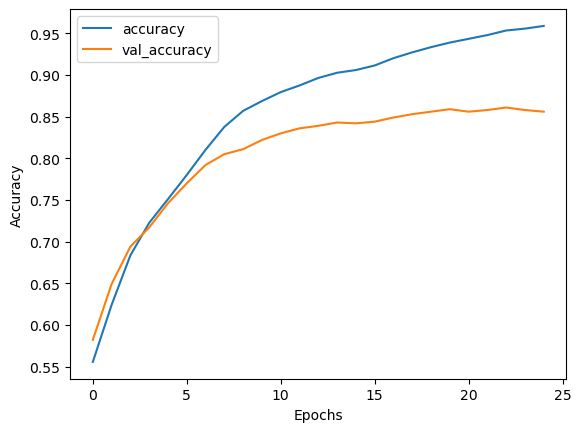

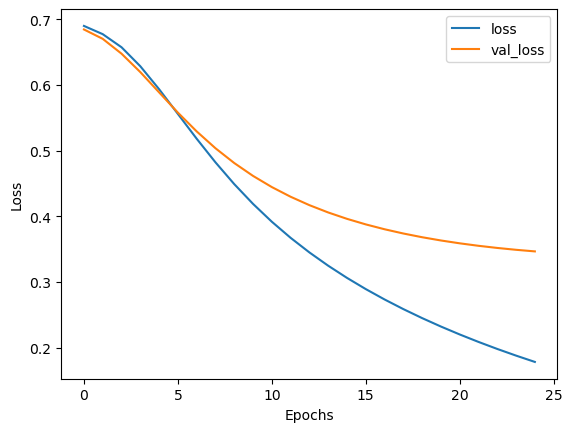

In [22]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric.title())
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_metrics(history, "accuracy")
plot_metrics(history, "loss")

In [23]:
#######Predict on Your Own Data
# Make a new sequential model using the vectorization layer and the model you just trained.
export_model = tf.keras.Sequential([
  vectorize_layer,
  model]
)

# Compile the model
export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

In [25]:
examples = ['this movie was very, very good', 'quite ok', 'the movie was not bad', 'bad', 'negative disappointed bad scary', 'this movie was stupid']

examples_tensor = tf.convert_to_tensor(examples, dtype=tf.string)  # Convert list to TensorFlow tensor of strings

results = export_model.predict(examples_tensor, verbose=False)

for result, example in zip(results, examples):
    print(f'Result: {result[0]:.3f},   Label: {int(np.round(result[0]))},   Review: {example}')

Result: 0.548,   Label: 1,   Review: this movie was very, very good
Result: 0.456,   Label: 0,   Review: quite ok
Result: 0.304,   Label: 0,   Review: the movie was not bad
Result: 0.349,   Label: 0,   Review: bad
Result: 0.308,   Label: 0,   Review: negative disappointed bad scary
Result: 0.359,   Label: 0,   Review: this movie was stupid


In [ ]:
#Hidden State Activation 

In [32]:
# Create some dummy data

w_hh = np.full((3, 2), 1)  # illustration purposes only, returns an array of size 3x2 filled with all 1s
w_hx = np.full((3, 3), 9)  # illustration purposes only, returns an array of size 3x3 filled with all 9s


### START CODE HERE ###
# Try using some random initializations, though it will obfuscate the join. eg: uncomment these lines
# w_hh = np.random.standard_normal((3,2))
# w_hx = np.random.standard_normal((3,3))
### END CODE HERE ###
#col concate
print("-- Data --\n")
print("w_hh :")
print(w_hh)
print("w_hh shape :", w_hh.shape, "\n")
print("w_hx :")
print(w_hx)
print("w_hx shape :", w_hx.shape, "\n")

# Joining the arrays
print("-- Joining --\n")
# Option 1: concatenate - horizontal
w_h1 = np.concatenate((w_hh, w_hx), axis=1)
print("option 1 : concatenate\n")
print("w_h :")
print(w_h1)
print("w_h shape :", w_h1.shape, "\n")

# Option 2: hstack
w_h2 = np.hstack((w_hh, w_hx))
print("option 2 : hstack\n")
print("w_h :")
print(w_h2)
print("w_h shape :", w_h2.shape)

-- Data --

w_hh :
[[1 1]
 [1 1]
 [1 1]]
w_hh shape : (3, 2) 

w_hx :
[[9 9 9]
 [9 9 9]
 [9 9 9]]
w_hx shape : (3, 3) 

-- Joining --

option 1 : concatenate

w_h :
[[1 1 9 9 9]
 [1 1 9 9 9]
 [1 1 9 9 9]]
w_h shape : (3, 5) 

option 2 : hstack

w_h :
[[1 1 9 9 9]
 [1 1 9 9 9]
 [1 1 9 9 9]]
w_h shape : (3, 5)


In [31]:
# Create some more dummy data
h_t_prev = np.full((2, 1), 1)  # illustration purposes only, returns an array of size 2x1 filled with all 1s
x_t = np.full((3, 1), 9)       # illustration purposes only, returns an array of size 3x1 filled with all 9s

# Try using some random initializations, though it will obfuscate the join. eg: uncomment these lines
#row concate
### START CODE HERE ###
# h_t_prev = np.random.standard_normal((2,1))
# x_t = np.random.standard_normal((3,1))
### END CODE HERE ###

print("-- Data --\n")
print("h_t_prev :")
print(h_t_prev)
print("h_t_prev shape :", h_t_prev.shape, "\n")
print("x_t :")
print(x_t)
print("x_t shape :", x_t.shape, "\n")

# Joining the arrays
print("-- Joining --\n")

# Option 1: concatenate - vertical
ax_1 = np.concatenate(
    (h_t_prev, x_t), axis=0
)  # note the difference in axis parameter vs earlier
print("option 1 : concatenate\n")
print("ax_1 :")
print(ax_1)
print("ax_1 shape :", ax_1.shape, "\n")

# Option 2: vstack
ax_2 = np.vstack((h_t_prev, x_t))
print("option 2 : vstack\n")
print("ax_2 :")
print(ax_2)
print("ax_2 shape :", ax_2.shape)

-- Data --

h_t_prev :
[[1]
 [1]]
h_t_prev shape : (2, 1) 

x_t :
[[9]
 [9]
 [9]]
x_t shape : (3, 1) 

-- Joining --

option 1 : concatenate

ax_1 :
[[1]
 [1]
 [9]
 [9]
 [9]]
ax_1 shape : (5, 1) 

option 2 : vstack

ax_2 :
[[1]
 [1]
 [9]
 [9]
 [9]]
ax_2 shape : (5, 1)


In [37]:
# Data

w_hh = np.full((3, 2), 1)  # returns an array of size 3x2 filled with all 1s
w_hx = np.full((3, 3), 9)  # returns an array of size 3x3 filled with all 9s
h_t_prev = np.full((2, 1), 1)  # returns an array of size 2x1 filled with all 1s
x_t = np.full((3, 1), 9)       # returns an array of size 3x1 filled with all 9s


# If you want to randomize the values, uncomment the next 4 lines

# w_hh = np.random.standard_normal((3,2))
# w_hx = np.random.standard_normal((3,3))
# h_t_prev = np.random.standard_normal((2,1))
# x_t = np.random.standard_normal((3,1))

# Results
print("-- Results --")
# Formula 1
stack_1 = np.hstack((w_hh, w_hx))
stack_2 = np.vstack((h_t_prev, x_t))

print("\nFormula 1")
print("Term1:\n",stack_1)
print("Term2:\n",stack_2)
formula_1 = np.matmul(np.hstack((w_hh, w_hx)), np.vstack((h_t_prev, x_t))) #ℎ<𝑡>=𝑔(𝑊ℎ[ℎ<𝑡−1>,𝑥<𝑡>]+𝑏ℎ)
print("Output:")
print(formula_1)

# Formula 2
mul_1 = np.matmul(w_hh, h_t_prev)
mul_2 = np.matmul(w_hx, x_t)
print("\nFormula 2")
print("Term1:\n",mul_1)
print("Term2:\n",mul_2)

formula_2 = np.matmul(w_hh, h_t_prev) + np.matmul(w_hx, x_t) #ℎ<𝑡>=𝑔(𝑊ℎℎℎ<𝑡−1>+𝑊ℎ𝑥𝑥<𝑡>+𝑏ℎ)
print("\nOutput:")
print(formula_2, "\n")

# Verification 
# np.allclose - to check if two arrays are elementwise equal upto certain tolerance, here  
# https://numpy.org/doc/stable/reference/generated/numpy.allclose.html

print("-- Verify --")
print("Results are the same :", np.allclose(formula_1, formula_2))

### START CODE HERE ###
# # Try adding a sigmoid activation function and bias term as a final check
# # Activation
# def sigmoid(x):
#     return 1 / (1 + np.exp(-x))

# # Bias and check
# b = np.random.standard_normal((formula_1.shape[0],1))
# print("Formula 1 Output:\n",sigmoid(formula_1+b))
# print("Formula 2 Output:\n",sigmoid(formula_2+b))

# all_close = np.allclose(sigmoid(formula_1+b), sigmoid(formula_2+b))
# print("Results after activation are the same :",all_close)
### END CODE HERE ###

-- Results --

Formula 1
Term1:
 [[1 1 9 9 9]
 [1 1 9 9 9]
 [1 1 9 9 9]]
Term2:
 [[1]
 [1]
 [9]
 [9]
 [9]]
Output:
[[245]
 [245]
 [245]]

Formula 2
Term1:
 [[2]
 [2]
 [2]]
Term2:
 [[243]
 [243]
 [243]]

Output:
[[245]
 [245]
 [245]] 

-- Verify --
Results are the same : True


In [36]:
#Formula 1:  ℎ<𝑡>=𝑔(𝑊ℎ[ℎ<𝑡−1>,𝑥<𝑡>]+𝑏ℎ)
 

#Formula 2:  ℎ<𝑡>=𝑔(𝑊ℎℎℎ<𝑡−1>+𝑊ℎ𝑥𝑥<𝑡>+𝑏ℎ)
 


In [45]:
#########Forward method
def sigmoid(x): # Sigmoid function
    return 1.0 / (1.0 + np.exp(-x))

In [46]:
random.seed(10)                 # Random seed, so your results match ours
emb = 128                       # Embedding size
T = 256                         # Length of sequence
h_dim = 16                      # Hidden state dimension
h_0 = np.zeros((h_dim, 1))      # Initial hidden state

# Random initialization of weights (w1, w2, w3) and biases (b1, b2, b3)
w1 = random.standard_normal((h_dim, emb + h_dim))
w2 = random.standard_normal((h_dim, emb + h_dim))
w3 = random.standard_normal((h_dim, emb + h_dim))
b1 = random.standard_normal((h_dim, 1))
b2 = random.standard_normal((h_dim, 1))
b3 = random.standard_normal((h_dim, 1))
# Random initialization of input X
# Note that you add the third dimension (1) to achieve the batch representation.
X = random.standard_normal((T, emb, 1))

# Define the lists of weights as you will need them for the two different layers
weights_vanilla = [w1, b1]
weights_GRU = [w1.copy(), w2, w3, b1.copy(), b2, b3]

In [47]:
# forward method for vanilla RNN
def forward_V_RNN(inputs, weights): # Forward propagation for a a single vanilla RNN cell
    x, h_t = inputs

    # weights.
    wh, bh = weights

    # new hidden state
    h_t = np.dot(wh, np.concatenate([h_t, x])) + bh
    h_t = sigmoid(h_t)
    
    # We avoid implementation of y for clarity
    y = h_t
    
    return y, h_t

In [48]:
# forward method for GRUs
def forward_GRU(inputs, weights): # Forward propagation for a single GRU cell
    x, h_t = inputs

    # weights.
    wu, wr, wc, bu, br, bc = weights

    # Update gate
    u = np.dot(wu, np.concatenate([h_t, x])) + bu
    u = sigmoid(u)
    
    # Relevance gate
    r = np.dot(wr, np.concatenate([h_t, x])) + br
    r = sigmoid(r)
    
    # Candidate hidden state 
    c = np.dot(wc, np.concatenate([r * h_t, x])) + bc
    c = np.tanh(c)
    
    # New Hidden state h_t
    h_t = u * c + (1 - u) * h_t
    
    # We avoid implementation of y for clarity
    y = h_t
    
    return y, h_t

In [49]:
forward_GRU([X[1], h_0], weights_GRU)[0]

array([[ 9.77779014e-01],
       [-9.97986240e-01],
       [-5.19958083e-01],
       [-9.99999886e-01],
       [-9.99707004e-01],
       [-3.02197037e-04],
       [-9.58733503e-01],
       [ 2.10804828e-02],
       [ 9.77365398e-05],
       [ 9.99833090e-01],
       [ 1.63200940e-08],
       [ 8.51874303e-01],
       [ 5.21399924e-02],
       [ 2.15495959e-02],
       [ 9.99878828e-01],
       [ 9.77165472e-01]])

In [ ]:
#scan function, allow to use GPUs and compute in parallel 

In [50]:
def scan(fn, elems, weights, h_0): # Forward propagation for RNNs
    h_t = h_0
    ys = []
    
    for x in elems:
        y, h_t = fn([x, h_t], weights)
        ys.append(y)
        
    return ys, h_t

In [51]:
ys, h_T = scan(forward_V_RNN, X, weights_vanilla, h_0)

print(f"Length of ys: {len(ys)}")
print(f"Shape of each y within ys: {ys[0].shape}")
print(f"Shape of h_T: {h_T.shape}")

Length of ys: 256
Shape of each y within ys: (16, 1)
Shape of h_T: (16, 1)


In [ ]:
#Comparison between vanilla RNNs and GRUs
#small training set

In [58]:
# vanilla RNNs
tic = perf_counter()
ys, h_T = scan(forward_V_RNN, X, weights_vanilla, h_0)
toc = perf_counter()
RNN_time=(toc-tic)*1000
print (f"It took {RNN_time:.2f}ms to run the forward method for the vanilla RNN.")

It took 7.53ms to run the forward method for the vanilla RNN.


In [57]:
# GRUs
tic = perf_counter()
ys, h_T = scan(forward_GRU, X, weights_GRU, h_0)
toc = perf_counter()
GRU_time=(toc-tic)*1000
print (f"It took {GRU_time:.2f}ms to run the forward method for the GRU.")

It took 10.22ms to run the forward method for the GRU.


In [ ]:
#GRUs take more time to compute

In [ ]:
#create a GRU model in tensorflow

In [59]:
model_GRU = tf.keras.Sequential([
    tf.keras.layers.GRU(256, return_sequences=True, name='GRU_1_returns_seq'),
    tf.keras.layers.GRU(128, return_sequences=True, name='GRU_2_returns_seq'),
    tf.keras.layers.GRU(64, name='GRU_3_returns_last_only'),
    tf.keras.layers.Dense(10)
])

In [60]:
# This line should fail
try:
    model_GRU.summary()
except Exception as e:
    print(e)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ GRU_1_returns_seq (GRU)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_2_returns_seq (GRU)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_3_returns_last_only (GRU)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [61]:
# Remember these three numbers and follow them further through the notebook
batch_size = 60
sequence_length = 50
word_vector_length = 40

input_data = tf.random.normal([batch_size, sequence_length, word_vector_length])

# Pass the data through the network
prediction = model_GRU(input_data)

# Show the summary of the model
model_GRU.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ GRU_1_returns_seq (GRU)         │ (60, 50, 256)          │       228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_2_returns_seq (GRU)         │ (60, 50, 128)          │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_3_returns_last_only (GRU)   │ (60, 64)               │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (60, 10)               │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 414,986 (1.58 MB)

 Trainable params: 414,986 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# Define some data with a different length of word vectors
#fail because Remember how the layers are constructed: they know what length of vectors to expect 
#and they have their weight matrices defined to accommodate for it. However if you change the length of the word vector,
#it cannot be multiplied by an incompatible matrix 
new_word_vector_length = 44  # Before it was 40
# Keep the batch_size = 60 and sequence_length = 50 as originally
input_data_1 = tf.random.normal([batch_size, sequence_length, new_word_vector_length])

# Pass the data through the network. This should Fail (if you ran all the cells above)
try:
    prediction = model_GRU(input_data_1)
except Exception as e:
    print(e)

Exception encountered when calling GRUCell.call().

{{function_node __wrapped__MatMul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Matrix size-incompatible: In[0]: [60,44], In[1]: [40,768] [Op:MatMul] name: 

Arguments received by GRUCell.call():
  • inputs=tf.Tensor(shape=(60, 44), dtype=float32)
  • states=('tf.Tensor(shape=(60, 256), dtype=float32)',)
  • training=False


In [65]:
#the neural network does not have any specific parameters (weights) associated with the length of the sequence
# Define some data with a different length of the sequence
new_sequence_length = 55  # Before it was 50
# Keep the batch_size = 60 and word_vector_length = 40 as originally
input_data_2 = tf.random.normal([batch_size, new_sequence_length, word_vector_length])

# Pass the data through the network. This should Fail (if you ran all the cells above)
prediction = model_GRU(input_data_2)

model_GRU.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ GRU_1_returns_seq (GRU)         │ (60, 50, 256)          │       228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_2_returns_seq (GRU)         │ (60, 50, 128)          │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_3_returns_last_only (GRU)   │ (60, 64)               │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (60, 10)               │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 414,986 (1.58 MB)

 Trainable params: 414,986 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
##How about batch_size, it's also flexible

In [66]:
# Define some data with a different batch size
new_batch_size = 66  # Before it was 60
# Keep the sequence_length = 50 and word_vector_length = 40 as originally
input_data_3 = tf.random.normal([new_batch_size, sequence_length, word_vector_length])

# Pass the data through the network. This should Fail (if you ran all the cells above)
prediction = model_GRU(input_data_3)

model_GRU.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ GRU_1_returns_seq (GRU)         │ (60, 50, 256)          │       228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_2_returns_seq (GRU)         │ (60, 50, 128)          │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_3_returns_last_only (GRU)   │ (60, 64)               │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (60, 10)               │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 414,986 (1.58 MB)

 Trainable params: 414,986 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Alternative: use model.build().

#Rather than passing data through the model, you can also specify the size of the data in an array and pass it to model.build(). 
#This will build the model, taking into account the data shape. You can also pass None, where the data dimension may change.

In [67]:
model_GRU_2 = tf.keras.Sequential([
    tf.keras.layers.GRU(256, return_sequences=True, name='GRU_1_returns_seq'),
    tf.keras.layers.GRU(128, return_sequences=True, name='GRU_2_returns_seq'),
    tf.keras.layers.GRU(64, name='GRU_3_returns_last_only'),
    tf.keras.layers.Dense(10)
])

model_GRU_2.build([None, None, word_vector_length])

model_GRU_2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ GRU_1_returns_seq (GRU)         │ (None, None, 256)      │       228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_2_returns_seq (GRU)         │ (None, None, 128)      │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_3_returns_last_only (GRU)   │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 414,986 (1.58 MB)

 Trainable params: 414,986 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
#Calculating perplexity
# Setting random seeds
np.random.seed(32)
# Load from .npy files
predictions = np.load('predictions.npy')
targets = np.load('targets.npy')

# Print shapes
print(f'predictions has shape: {predictions.shape}')
print(f'targets has shape: {targets.shape}')

reshaped_targets = np.eye(predictions.shape[-1])[targets]   #predictions.shape[-1] will return the size of the last dimension of predictions.
print(f'reshaped_targets has shape: {reshaped_targets.shape}')

log_p = np.sum(predictions * reshaped_targets, axis= -1)

#np.equal() and get a tensor with 1s in the positions of actual values and 0s
non_pad = 1.0 - np.equal(targets, 0)
print(f'non_pad has shape: {non_pad.shape}\n')
print(f'non_pad looks like this: \n\n {non_pad}')

predictions has shape: (32, 64, 256)
targets has shape: (32, 64)
reshaped_targets has shape: (32, 64, 256)
non_pad has shape: (32, 64)

non_pad looks like this: 

 [[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


In [70]:
#computing the product of the log probabilities and the non_pad tensor you remove the effect of padding on the metric:
real_log_p = log_p * non_pad
print(f'real log probabilities still have shape: {real_log_p.shape}')

real log probabilities still have shape: (32, 64)


In [71]:
#check the effect of filtering out the padding by looking at the two log probabilities tensors:
print(f'log probabilities before filtering padding: \n\n {log_p}\n')
print(f'log probabilities after filtering padding: \n\n {real_log_p}')

log probabilities before filtering padding: 

 [[ -5.39654493  -1.03111839  -0.66916656 ... -22.37672997 -23.18770981
  -21.84348297]
 [ -4.58577061  -1.13412857  -8.53803253 ... -20.15686035 -26.83709717
  -23.57501984]
 [ -5.22238874  -1.28241444  -0.17312431 ... -21.328228   -19.85441208
  -33.88444138]
 ...
 [ -5.39654493 -17.29168129  -4.36076593 ... -20.82580185 -21.06583786
  -22.44311523]
 [ -5.93131638 -14.24741745  -0.26373291 ... -26.74324799 -18.38433075
  -22.35527802]
 [ -5.67053604  -0.10595131   0.         ... -23.33252335 -28.08737564
  -23.87880707]]

log probabilities after filtering padding: 

 [[ -5.39654493  -1.03111839  -0.66916656 ...  -0.          -0.
   -0.        ]
 [ -4.58577061  -1.13412857  -8.53803253 ...  -0.          -0.
   -0.        ]
 [ -5.22238874  -1.28241444  -0.17312431 ...  -0.          -0.
   -0.        ]
 ...
 [ -5.39654493 -17.29168129  -4.36076593 ...  -0.          -0.
   -0.        ]
 [ -5.93131638 -14.24741745  -0.26373291 ...  -0.        

In [72]:
#sum the log probabilities in each sequence and divide by the number of non padding elements
log_ppx = np.sum(real_log_p, axis=1) / np.sum(non_pad, axis=1)
log_ppx = np.mean(-log_ppx)
print(f'The log perplexity and perplexity of the model are respectively: {log_ppx} and {np.exp(log_ppx)}')

The log perplexity and perplexity of the model are respectively: 2.6211854987065033 and 13.752016923578548
